本notebook的CNN模型是ResNet网络

## 1、导入相关包

In [1]:
import os
from tqdm import tqdm
# 数据科学包
import random                      # 随机切分数据集
import numpy as np                 # 常用数据科学包
from PIL import Image              # 图像读取
import matplotlib.pyplot as plt    # 代码中快速验证
import cv2                         # 图像包

# 深度学习包
import paddle
import paddle.vision.transforms as tf      # 数据增强
from paddle.io import Dataset, DataLoader  # 定义数据集
import paddle.nn as nn                     # 网络

/root/miniconda3/envs/paddle/lib/python3.8/site-packages/setuptools/sandbox.py:13: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#key

## 2、准备数据集

解压数据集

In [2]:
if not os.path.exists('data/cat_12_train'):
    !unzip data/cat_12_train.zip
if not os.path.exists('data/cat_12_test'):
    !unzip data/cat_12_test.zip

划分数据集

In [3]:
train_ratio = 0.9  # 训练集占0.9，验证集占0.1

train_paths, train_labels = [], []
valid_paths, valid_labels = [], []
with open('data/train_list.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if random.uniform(0, 1) < train_ratio:
            train_paths.append('data/' + line.split('	')[0])
            label = line.split('	')[1]
            train_labels.append(int(line.split('	')[1]))
        else:
            valid_paths.append('data/' + line.split('	')[0])
            valid_labels.append(int(line.split('	')[1]))

定义数据集

In [4]:
# 定义训练数据集
class TrainData(Dataset):
    def __init__(self):
        super().__init__()
        self.color_jitter = tf.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
        self.normalize = tf.Normalize(mean=0, std=1)
        self.random_crop = tf.RandomCrop(224, pad_if_needed=True)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = train_paths[index]
        # Height Weight Channel
        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # single channel copies
        
        # 图像增广
        features = self.color_jitter(image.transpose([1, 2, 0]))
        features = self.random_crop(features)
        features = self.normalize(features.transpose([2, 0, 1])).astype(np.float32)

        # 读取标签
        labels = train_labels[index]

        return features, labels
    
    def __len__(self):
        return len(train_paths)

    
# 定义验证数据集
class ValidData(Dataset):
    def __init__(self):
        super().__init__()
        self.normalize = tf.Normalize(mean=0, std=1)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = valid_paths[index]

        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # single channel copies
        
        # 图像变换
        features = cv2.resize(image.transpose([1, 2, 0]), (256, 256)).transpose([2, 0, 1]).astype(np.float32)
        features = self.normalize(features)

        # 读取标签
        labels = valid_labels[index]

        return features, labels
    
    def __len__(self):
        return len(valid_paths)

查看对图像进行的增广变换


label: 11



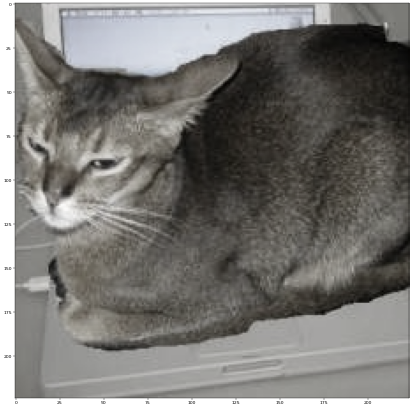

In [5]:
train_data = TrainData()
img, labels = train_data.__getitem__(98)
print('label: '+str(label))
plt.figure(dpi=32,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))
plt.show()

label: 7


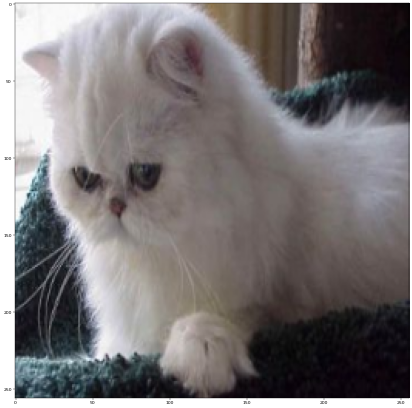

In [6]:
valid_data = ValidData()
img, label = valid_data.__getitem__(134)
print('label: '+str(label))
plt.figure(dpi=32,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))

## 3、准备网络模型

搭建网络

In [7]:
# 定义CNN模型：ResNet
class BottleneckBlock(nn.Layer):

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2D
        width = int(planes * (base_width / 64.0)) * groups

        self.conv1 = nn.Conv2D(inplanes, width, 1, bias_attr=False)
        self.bn1 = norm_layer(width)

        self.conv2 = nn.Conv2D(
            width,
            width,
            3,
            padding=dilation,
            stride=stride,
            groups=groups,
            dilation=dilation,
            bias_attr=False,
        )
        self.bn2 = norm_layer(width)

        self.conv3 = nn.Conv2D(
            width, planes * self.expansion, 1, bias_attr=False
        )
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Layer):
    """ResNet model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        Block (BasicBlock|BottleneckBlock): Block module of model.
        depth (int, optional): Layers of ResNet, Default: 50.
        width (int, optional): Base width per convolution group for each convolution block, Default: 64.
        num_classes (int, optional): Output dim of last fc layer. If num_classes <= 0, last fc layer
                            will not be defined. Default: 1000.
        with_pool (bool, optional): Use pool before the last fc layer or not. Default: True.
        groups (int, optional): Number of groups for each convolution block, Default: 1.

    Returns:
        :ref: An instance of ResNet model.

    """

    def __init__(
        self,
        block = BottleneckBlock,
        depth=50,
        width=64,
        num_classes=1000,
        with_pool=True,
        groups=1,
    ):
        super().__init__()
        layer_cfg = {
            18: [2, 2, 2, 2],
            34: [3, 4, 6, 3],
            50: [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3],
        }
        layers = layer_cfg[depth]
        self.groups = groups
        self.base_width = width
        self.num_classes = num_classes
        self.with_pool = with_pool
        self._norm_layer = nn.BatchNorm2D

        self.inplanes = 64
        self.dilation = 1

        self.conv1 = nn.Conv2D(
            3,
            self.inplanes,
            kernel_size=7,
            stride=2,
            padding=3,
            bias_attr=False,
        )
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        if with_pool:
            self.avgpool = nn.AdaptiveAvgPool2D((1, 1))

        if num_classes > 0:
            self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2D(
                    self.inplanes,
                    planes * block.expansion,
                    1,
                    stride=stride,
                    bias_attr=False,
                ),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.with_pool:
            x = self.avgpool(x)

        if self.num_classes > 0:
            x = paddle.flatten(x, 1)
            x = self.fc(x)

        return x


resnet50 = ResNet(BottleneckBlock, 50,  num_classes=12)


W1224 07:03:30.873759 38661 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 12.2, Runtime API Version: 11.7
W1224 07:03:30.882467 38661 gpu_resources.cc:91] device: 0, cuDNN Version: 8.5.


查看网络结构

In [8]:
# print(resnet150)
# 获取模型结构文件
paddle.jit.save(resnet50, './model/cnn_model', [paddle.static.InputSpec([None, 3, None, None])])

/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, w

下载预训练模型

In [9]:
!mkdir pretrained_models
if not os.path.exists('pretrained_models/ResNet50_pretrained'): 
    !wget https://paddle-imagenet-models-name.bj.bcebos.com/ResNet50_pretrained.tar
    !tar -xvf ResNet50_pretrained.tar

    !mv ResNet50_pretrained pretrained_models/
    !rm ResNet50_pretrained.tar


mkdir: cannot create directory ‘pretrained_models’: File exists


载入预训练模型

In [10]:
model = resnet50

pretrain_model_path = './model/cnn/final.pdparams'# 'pretrained_models/ResNet50_pretrained'

# 加载预训练模型参数
model.set_state_dict(paddle.load(pretrain_model_path))

/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1517: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 1000], but the expected shape is [2048, 12].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1517: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [12].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


当然，也可以直接使用paddle官方api调用resnet50模型
```python
paddle.vision.set_image_backend('cv2') # 将图像处理后端设置为 OpenCV
paddle.vision.models.resnet50(pretrained=True, num_classes=12)
```
[官方文档](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#about-models)


## 4、模型训练

In [11]:
epochs = 100
batch_size = 32

# 设置GPU环境，如果没有GPU则设置为CPU
if paddle.is_compiled_with_cuda() and paddle.get_device() != 'cpu':
    paddle.set_device('gpu:0')
    print("Using GPU.")
else:
    paddle.set_device('cpu')
    print("Using CPU.")

# 定义数据迭代器
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=False)

# 定义优化器
opt = paddle.optimizer.Adam(learning_rate=1e-4, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-4))

# 定义损失函数
loss_fn = paddle.nn.CrossEntropyLoss()

# 用于测量准确率的评价指标对象
metric =  paddle.metric.Accuracy()

# 定义 EarlyStopping 回调函数
callback = paddle.callbacks.EarlyStopping(monitor='acc', patience=5, mode='max', verbose=1)
# 定义 ModelCheckpoint 回调函数
checkpoint_callback = paddle.callbacks.ModelCheckpoint(save_dir='./model/cnn', save_freq=2)
# 设置 visualdl 路径
log_dir = './visualdl/cnn'
visual_callback = paddle.callbacks.VisualDL(log_dir=log_dir)

# 使用高层API进行训练
model = paddle.Model(model) # 用 Model 封装
# 模型配置
model.prepare(opt, loss_fn, metric)
# 模型训练
model.fit(train_dataloader,
          valid_dataloader,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1,
          callbacks= [callback, checkpoint_callback, visual_callback])



Using GPU.
The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.3755 - acc: 0.6588 - 620ms/step          
save checkpoint at /home/.kun/.study/ANN/final/cat_classify/model/cnn/0
Eval begin...
step 7/7 [==============================] - loss: 0.4640 - acc: 0.8558 - 204ms/step
Eval samples: 208
Epoch 2/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.2078 - acc: 0.8478 - 649ms/step          
Eval begin...
step 7/7 [==============================] - loss: 0.3034 - acc: 0.8942 - 186ms/step
Eval samples: 208
Epoch 3/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.4994 - acc: 0.8806 - 639ms/step          
save checkpoint at /home/.kun/.study/ANN/final/cat_classify/model/cnn/2
Eval begin...
step 7/7 [==============================] - loss: 0.1691 - acc: 0.9087 - 178ms/step
Eval samples: 208
Epoch 4/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.2270 - acc: 0.8965 - 639ms/step          
Eval begin...
step 7/7 [==============================] - loss: 0.2001 - acc: 0.9183 - 189ms/step
Eval samples: 208
Epoch 5/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.2780 - acc: 0.9216 - 613ms/step          
save checkpoint at /home/.kun/.study/ANN/final/cat_classify/model/cnn/4
Eval begin...
step 7/7 [==============================] - loss: 0.4635 - acc: 0.8942 - 178ms/step
Eval samples: 208
Epoch 6/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.6237 - acc: 0.9124 - 625ms/step          
Eval begin...
step 7/7 [==============================] - loss: 0.2694 - acc: 0.8846 - 169ms/step
Eval samples: 208
Epoch 7/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.2886 - acc: 0.9226 - 636ms/step          
save checkpoint at /home/.kun/.study/ANN/final/cat_classify/model/cnn/6
Eval begin...
step 7/7 [==============================] - loss: 0.7811 - acc: 0.9087 - 182ms/step
Eval samples: 208
Epoch 8/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.1265 - acc: 0.9416 - 607ms/step          
Eval begin...
step 7/7 [==============================] - loss: 0.3104 - acc: 0.8894 - 181ms/step
Eval samples: 208
Epoch 9/100


/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/nn/layer/norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 61/61 [==============================] - loss: 0.1023 - acc: 0.9447 - 643ms/step          
save checkpoint at /home/.kun/.study/ANN/final/cat_classify/model/cnn/8
Eval begin...
step 7/7 [==============================] - loss: 0.5186 - acc: 0.8894 - 173ms/step
Eval samples: 208
Epoch 9: Early stopping.
save checkpoint at /home/.kun/.study/ANN/final/cat_classify/model/cnn/final


## 5、模型测试

模型预测

在测试集上预测，可以将生成的submit.csv文件提交比赛测试

In [12]:
# 预测文件的路径列表
def listdir(path, list_name):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            listdir(file_path, list_name)
        else:
            list_name.append(file_path)
test_path = []
listdir('data/cat_12_test', test_path)

# 加载训练好的模型
pre_model = paddle.vision.models.resnet50(pretrained=True, num_classes=12)
pre_model.set_state_dict(paddle.load('./model/cnn/final.pdparams'))
pre_model.eval()

pre_classes = []
normalize = tf.Normalize(mean=0, std=1)
# 生成预测结果
for path in test_path:
    image_path = path

    image = np.array(Image.open(image_path))    # H, W, C
    try:
        image = image.transpose([2, 0, 1])[:3]  # C, H, W
    except:
        image = np.array([image, image, image]) # C, H, W
    
    # 图像变换
    features = cv2.resize(image.transpose([1, 2, 0]), (256, 256)).transpose([2, 0, 1]).astype(np.float32)
    features = normalize(features)

    features = paddle.to_tensor([features])
    pre = list(np.array(pre_model(features)[0]))
    # print(pre)
    max_item = max(pre)
    pre = pre.index(max_item)
    # print("图片：", path, "预测结果：", pre)
    pre_classes.append(pre)

# print(pre_classes)

/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1517: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 1000], but the expected shape is [2048, 12].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/root/miniconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1517: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [12].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


结果提交

In [13]:
# 导入csv模块
import csv

# 1、创建文件对象
with open('submit.csv', 'w', encoding='gbk', newline="") as f:
    # 2、基于文件对象构建csv写入对象
    csv_writer = csv.writer(f)
    for i in range(240):
        csv_writer.writerow([test_path[i].split('/')[2], pre_classes[i]])
    print('写入数据完成')

写入数据完成
